# Analysis
- describe twitch
- describe steam

I am not a streamer, nor do I plan to start a streaming platform, however this analysis may help categorize games and show trends.

*https://medium.com/@streamedgeanalytics/how-to-pick-what-to-stream-on-twitch-7d19bbf7dd28* 

*https://theemergence.co.uk/how-to-choose-what-game-to-stream-on-twitch/*

- Should not choose to stream games just based on popularity
- 

*https://kotaku.com/streamers-are-misusing-twitchs-just-chatting-section-b-1844557615*

> “Accessing audiences is always a nightmare on Twitch because it’s built with viewer count in mind,” Bussey said. “Bigger streamers are always going to have the benefit of the top of directory placement, the same way that games do. But because the platform has been high-to-low for so long, existing users are used to scrolling multiple times down the page to find new content. And because Just Chatting appeals to all on a content level and on a direct communication level (one of the core reasons why live streaming is so interesting), more people are willing to make those long scrolls.”



In [75]:
import pandas as pd
import numpy as np
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import missingno as msno
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import datetime as dt
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

### Load in data

In [76]:
# Steam charts data
steam_data = pd.read_csv(r"data_files\steam_charts_final_clean.csv", parse_dates=["month","release_date"], index_col = "month")

# Global twitch data
twitch_global = pd.read_csv(r"data_files\twitch_global_data_clean.csv", parse_dates = ["date"], index_col = "date")

# Twitch game data
twitch_game = pd.read_csv(r"data_files\twitch_game_data_clean.csv", parse_dates=["date"], index_col = "date")

In [77]:
steam_data.head()

,average_players,peak_players,app_id,game,player_gain,player_gain_percentage,short_description,required_age,dlc,supported_languages,developers,publishers,platforms,categories,genres,achievements,release_date,supported_audio,price_usd,review_score,total_positive,total_negative,rating,total_owners_estimated,average_playtime,median_playtime,tags,metacritic_score,metacritic_url,is_recurring_subscription,year,month_name,release_year,release_month,age
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-30,570825.94,923996,730,Counter-Strike: Global Offensive,5864.20,1.04,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,June,2012,8,10
2022-05-31,564961.70,923996,730,Counter-Strike: Global Offensive,-4021.46,-0.71,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,May,2012,8,10
2022-04-30,568983.16,1013237,730,Counter-Strike: Global Offensive,-12506.53,-2.15,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,April,2012,8,10
2022-03-31,581489.69,987993,730,Counter-Strike: Global Offensive,-53148.71,-8.37,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,March,2012,8,10
2022-02-28,634638.40,995163,730,Counter-Strike: Global Offensive,32262.13,5.36,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,February,2012,8,10


In [78]:
steam_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51942 entries, 2022-06-30 to 2020-02-29
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   average_players            51942 non-null  float64       
 1   peak_players               51942 non-null  int64         
 2   app_id                     51942 non-null  int64         
 3   game                       51942 non-null  object        
 4   player_gain                51942 non-null  float64       
 5   player_gain_percentage     51942 non-null  float64       
 6   short_description          47466 non-null  object        
 7   required_age               51942 non-null  float64       
 8   dlc                        29870 non-null  object        
 9   supported_languages        47466 non-null  object        
 10  developers                 47466 non-null  object        
 11  publishers                 47466 non-null  object 

The median and mean of player_gain are close enough that the mean can be used to group by the game column

In [79]:
steam_data.resample("M")["average_players"].sum()

month
2012-07-31    364991.50
2012-08-31    361450.66
2012-09-30    415899.23
2012-10-31    384608.86
2012-11-30    394558.23
                ...    
2022-02-28   5718554.14
2022-03-31   5434299.62
2022-04-30   5106030.68
2022-05-31   5163519.50
2022-06-30   5251685.78
Freq: M, Name: average_players, Length: 120, dtype: float64

In [80]:
steam_data

,average_players,peak_players,app_id,game,player_gain,player_gain_percentage,short_description,required_age,dlc,supported_languages,developers,publishers,platforms,categories,genres,achievements,release_date,supported_audio,price_usd,review_score,total_positive,total_negative,rating,total_owners_estimated,average_playtime,median_playtime,tags,metacritic_score,metacritic_url,is_recurring_subscription,year,month_name,release_year,release_month,age
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-30,570825.94,923996,730,Counter-Strike: Global Offensive,5864.20,1.04,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,June,2012,8,10
2022-05-31,564961.70,923996,730,Counter-Strike: Global Offensive,-4021.46,-0.71,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,May,2012,8,10
2022-04-30,568983.16,1013237,730,Counter-Strike: Global Offensive,-12506.53,-2.15,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,April,2012,8,10
2022-03-31,581489.69,987993,730,Counter-Strike: Global Offensive,-53148.71,-8.37,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,March,2012,8,10
2022-02-28,634638.40,995163,730,Counter-Strike: Global Offensive,32262.13,5.36,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,February,2012,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,444.60,1019,625960,Stoneshard,-37.79,-7.83,Stoneshard is a challenging turn-based RPG set...,0.00,True,"['English', 'French', 'German', 'Italian', 'Ja...",['Ink Stains Games'],['HypeTrain Digital'],"['windows', 'linux']","['Single-player', 'Captions available', 'Remot...","['Adventure', 'Indie', 'RPG', 'Strategy', 'Ear...",54.00,2020-02-06,NaN,26.71,6.00,15281.00,4705.00,75.12,500000-10

### Column relationships for global twitch data
The twitch global dataset describes **overall** metrics for audience participation and channel information. This dataset excludes individual game data, which has been separated into its own dataset.

In the chart below, *Twitch global data correlations*, you'll see values of 0.88 and above. This indicates a strong positive relationship for the variables of this dataset. For example, as values in the column "Hours_watched" increase or decrease, the values in "Avg_viewers" follow the same trend (increase/decrease). However, correlation is not causation, thus an increase in one variable (column) does not neccessarily mean it directly influences another variable.

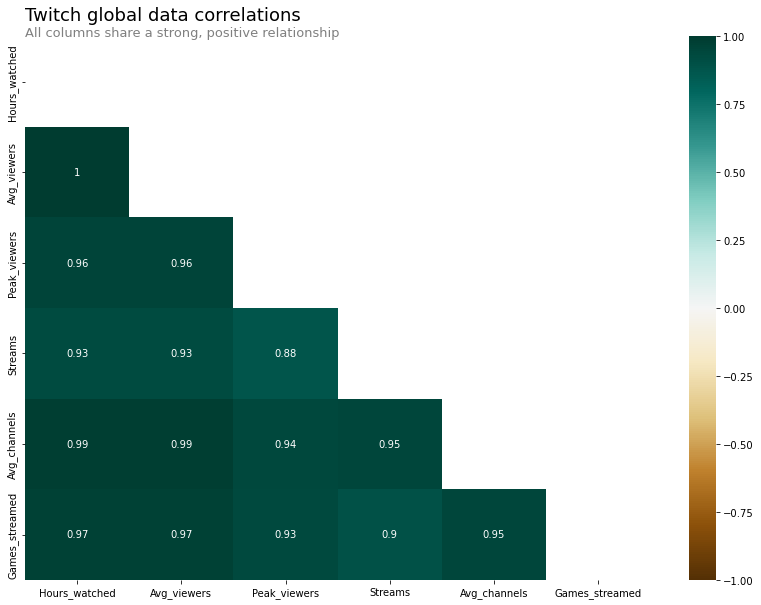

In [81]:
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(twitch_global.corr(), dtype=bool))

heatmap = sns.heatmap(twitch_global.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title("Twitch global data correlations", fontdict={'fontsize':18}, pad=16, loc = "left")
plt.text(x = 0, y = 0, s = "All columns share a strong, positive relationship ", size = 13, color = "grey")
plt.show()

### Column relationships for steam charts data

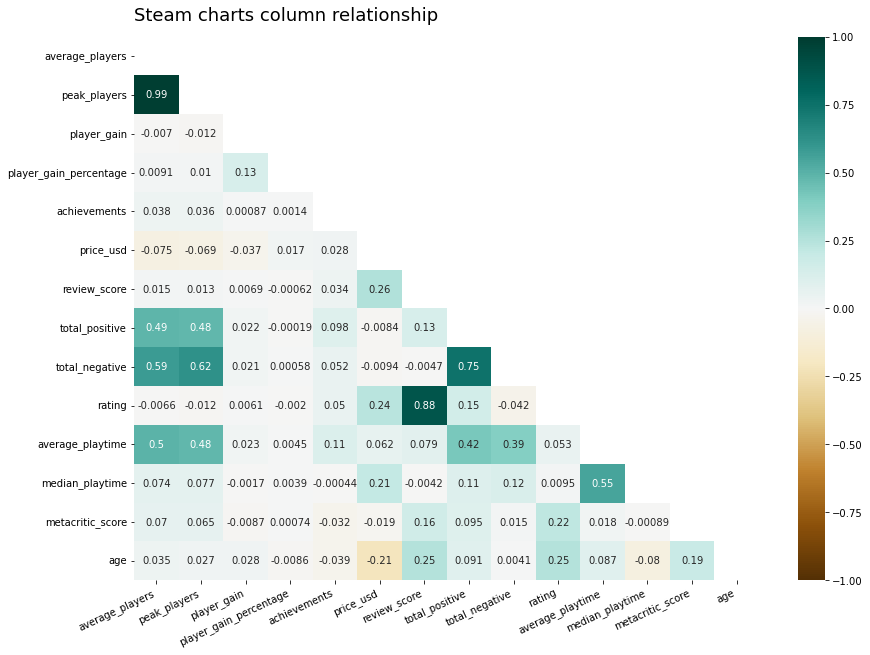

In [82]:

# Columns of interest for correlating
steam_charts_corr = steam_data[['average_players', 'peak_players','player_gain',
       'player_gain_percentage','achievements','price_usd', 'review_score', 'total_positive',
       'total_negative', 'rating','average_playtime', 'median_playtime','metacritic_score','age']]

# Plot results
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(steam_charts_corr.corr(), dtype=bool))

# Heatmap
heatmap = sns.heatmap(steam_charts_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Set title
heatmap.set_title("Steam charts column relationship", fontdict={'fontsize':18}, pad=16, loc = "left")
plt.xticks(rotation = 25, ha = "right")
plt.show()

### Steam and Twitch general trends

The two charts below, *Steam: total monthly players (2012 - 2022)*, and *Twitch: total monthly viewers (2016 - 2022)*, visualize consumer trends for Valve's Steam client, and Amazon's video game streaming platform.

Do these two platforms have a viable audience? The data shows that since 2012, the total number of people using Valve's client has seen positive growth. The current information suggests that Steam is still a widely used application for PC gaming.

Total monthly users reflect a smaller portion than the true total monthly players. The reason for this is that the analyzed data is a sample of 1,000 games out of the 60,000+ library available on Steam.
However, I think it's fair to say that the popularity of Valve's Steam client is gaining in popularity.

Twitch's audience shows a similar trend since 2016. Interestingly, there is a large spike in the average number of hours watched in 2020. It's likely this was caused by the COVID-19 lockdowns. As more people stayed home, Twitch was a form of entertainment for millions of people.



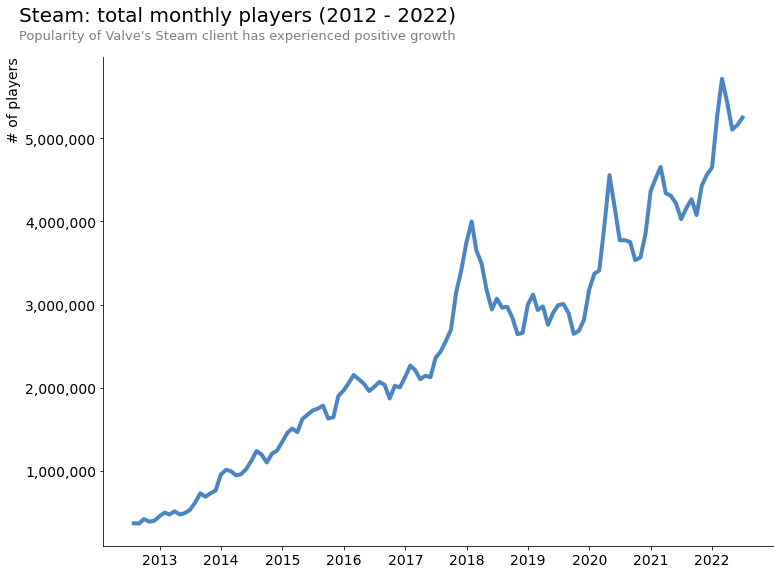

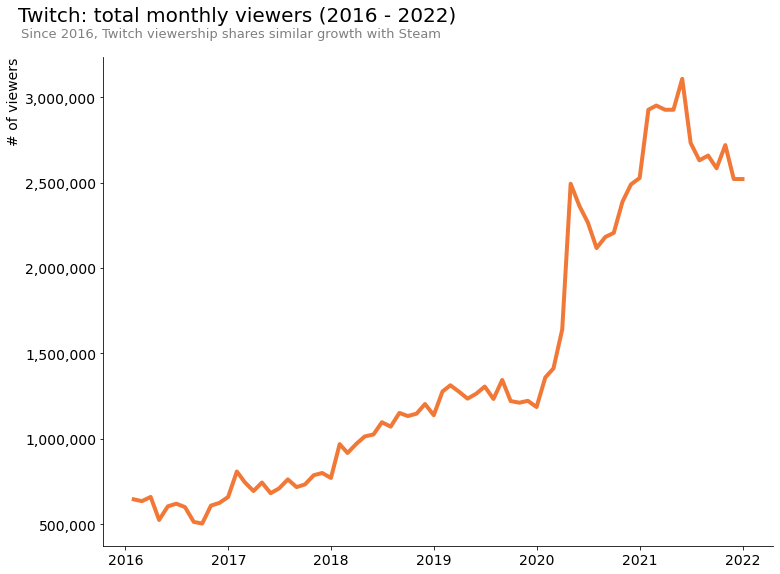

In [83]:
# Steam data
# Plot results
fig, ax = plt.subplots(figsize = (12,9))

# Resample the player data on a monthly scale, calculate the sum
plt.plot(steam_data.resample("M")["average_players"].sum(), color = "#4B86C1", linewidth = 4)

# Remove borders
plt.gca().spines[["right", "top"]].set_visible(False)

# Change y tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Set x axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Title and subtext
plt.title("Steam: total monthly players (2012 - 2022)", size = 20, x = 0.2, y = 1.06)
plt.text(x = 14870, y = 6200000, 
s= "Popularity of Valve's Steam client has experienced positive growth", size = 13, color = "grey")


# Labels and tick markers
plt.ylabel("# of players", size = 14, loc = "top")
plt.yticks(size = 14)
plt.xticks(size = 14)
#plt.ylim(0)
plt.show()

#############################################################################################################

# Global twitch data
# Plot results
fig, ax = plt.subplots(figsize = (12,9))

# Resample the twitch data on a monthly scale, calculate the sum of average viewers
plt.plot(twitch_global.resample("M")["Avg_viewers"].sum(), color = "#f17837", linewidth = 4)

# Remove borders
plt.gca().spines[["right", "top"]].set_visible(False)

# Change y tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Set x axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Title and subtext
plt.title("Twitch: total monthly viewers (2016 - 2022)", size = 20, x = 0.20, y = 1.06)
plt.text(x = 16430, y = 3350000, 
s= "Since 2016, Twitch viewership shares similar growth with Steam", size = 13, color = "grey")

# Labels and tick markers
plt.ylabel("# of viewers", size = 14, loc = "top")
plt.yticks(size = 14)
plt.xticks(size = 14)

plt.show()

### Twitch time series disregarding pandemic <- Here

In [84]:
### Time series for this title ^^^^^

In [85]:
twitch_global

,Hours_watched,Avg_viewers,Peak_viewers,Streams,Avg_channels,Games_streamed
date,,,,,,
2016-01-31,480241904,646355,1275257,7701675,20076,12149
2016-02-29,441859897,635769,1308032,7038520,20427,12134
2016-03-31,490669308,660389,1591551,7390957,20271,12234
2016-04-30,377975447,525696,1775120,6869719,16791,12282
2016-05-31,449836631,605432,1438962,7535519,19394,12424
...,...,...,...,...,...,...
2021-08-31,1974586275,2657585,4778502,20767741,100701,36471
2021-09-30,1857514531,2583469,5599210,18826493,95513,35861
2021-10-31,2020197953,2718974,6086487,18209793,91858,36406


In [86]:
forecast_data = twitch_global.copy()
forecast_data.index.freq = "M"


In [87]:
forecast_data

,Hours_watched,Avg_viewers,Peak_viewers,Streams,Avg_channels,Games_streamed
date,,,,,,
2016-01-31,480241904,646355,1275257,7701675,20076,12149
2016-02-29,441859897,635769,1308032,7038520,20427,12134
2016-03-31,490669308,660389,1591551,7390957,20271,12234
2016-04-30,377975447,525696,1775120,6869719,16791,12282
2016-05-31,449836631,605432,1438962,7535519,19394,12424
...,...,...,...,...,...,...
2021-08-31,1974586275,2657585,4778502,20767741,100701,36471
2021-09-30,1857514531,2583469,5599210,18826493,95513,35861
2021-10-31,2020197953,2718974,6086487,18209793,91858,36406


In [88]:
# Train test split
train_data = forecast_data.loc[:"2019-12-31"]
test_data = forecast_data.loc["2020-01-31":"2021-12-31"]

In [89]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [90]:
fitted_model = ExponentialSmoothing(train_data["Avg_viewers"], trend="mul", seasonal="mul",seasonal_periods=12).fit()

In [91]:
test_predictons = fitted_model.forecast(24)

In [92]:
test_predictons

2020-01-31   1439427.10
2020-02-29   1382245.59
2020-03-31   1354174.62
2020-04-30   1389710.28
2020-05-31   1367343.00
2020-06-30   1437184.04
2020-07-31   1442565.86
2020-08-31   1377926.80
2020-09-30   1370641.78
2020-10-31   1492227.86
2020-11-30   1533411.74
2020-12-31   1512917.56
2021-01-31   1814668.35
2021-02-28   1742580.31
2021-03-31   1707191.58
2021-04-30   1751990.96
2021-05-31   1723792.79
2021-06-30   1811840.55
2021-07-31   1818625.35
2021-08-31   1737135.66
2021-09-30   1727951.53
2021-10-31   1881233.63
2021-11-30   1933153.66
2021-12-31   1907316.88
Freq: M, dtype: float64

Text(19020, 1900000, 'Predicted')

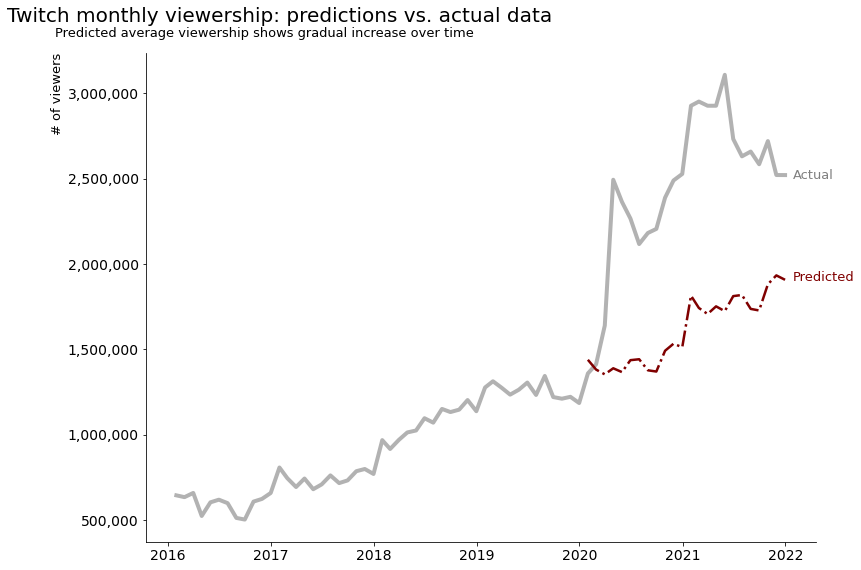

In [93]:
fig, ax = plt.subplots(figsize = (12,9))

# Training data
#plt.plot(train_data.index, train_data["Avg_viewers"])

# Test data
#plt.plot(test_data.index, test_data["Avg_viewers"], color = "maroon", linewidth = 3, alpha = 0.5)

plt.plot(twitch_global.index, twitch_global["Avg_viewers"], color = "grey", linewidth=4, alpha =0.6)
# Predictions
plt.plot(test_predictons, color = "maroon", linewidth = 2.5, linestyle= "-.")

# Change y tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Set y axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Remove borders
plt.gca().spines[["right", "top"]].set_visible(False)

# X and Y ticks
plt.yticks(size = 14)
plt.xticks(size = 14)

plt.ylabel("# of viewers", size = 13, loc = "top")

plt.title("Twitch monthly viewership: predictions vs. actual data", size = 20, x = 0.2, y = 1.05)
plt.text(x =16400 ,y = 3330000, s = "Predicted average viewership shows gradual increase over time", size = 13)

plt.text(x = 19020, y = 2500000, s = "Actual", size = 13, color = "grey")

plt.text(x = 19020, y = 1900000, s = "Predicted", size = 13, color = "maroon")

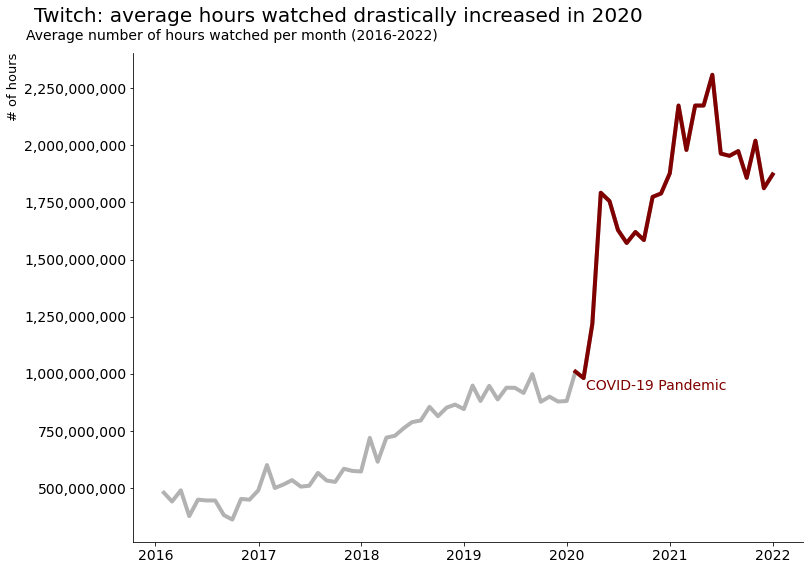

In [94]:
# Twitch viewership 2020 and onward
# Highlights all data past January 31, 2020
pandemic = twitch_global.loc["2020-01-31":] # <- WHO Issues Global Health Emergency

# Plot results
fig, ax = plt.subplots(figsize = (12,9))

plt.plot(twitch_global.resample("M")["Hours_watched"].sum(), color = "grey", linewidth = 4, alpha = 0.6)
plt.plot(pandemic.resample("M")["Hours_watched"].sum(), color = "maroon", linewidth = 4)

# Change y tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Set y axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Title and subtext
plt.title("Twitch: average hours watched drastically increased in 2020 ", size = 20, x = 0.31, y = 1.05)
plt.text(x = 16340, y = 2460000000, 
s= "Average number of hours watched per month (2016-2022)", size = 14)


# Remove borders
plt.gca().spines[["right", "top"]].set_visible(False)

# X and Y ticks
plt.yticks(size = 14)
plt.xticks(size = 14)

# Label
plt.text(x = 18330, y = 930000000, 
s= "COVID-19 Pandemic", size = 14, color = "maroon")

plt.ylabel("# of hours", size = 13, loc = "top")
plt.show()


In [95]:
steam_data.describe()

,average_players,peak_players,app_id,player_gain,player_gain_percentage,required_age,achievements,price_usd,review_score,total_positive,total_negative,rating,average_playtime,median_playtime,metacritic_score,year,release_year,release_month,age
count,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00
mean,5803.58,11219.46,438313.71,-133.26,14348.79,2.47,63.42,20.70,7.35,49776.64,6228.47,82.61,2925.67,1058.94,81.23,2018.69,2015.48,6.83,6.52
std,36838.04,68895.73,364967.25,6273.96,1108054.41,6.07,119.40,15.86,1.87,170035.18,35032.29,11.72,4342.96,3150.74,5.46,2.52,3.91,3.47,3.91
min,0.00,0.00,10.00,-310597.48,-100.00,0.00,0.00,0.00,0.00,0.00,0.00,26.97,0.00,0.00,56.00,2012.00,1998.00,1.00,0.00
25%,372.12,780.00,221100.00,-133.64,-13.67,0.00,5.00,8.75,7.35,5068.00,628.00,78.84,905.00,286.00,81.23,2017.00,2013.00,4.00,4.00
50%,814.93,1708.00,346010.00,-6.88,-1.74,0.00,43.00,20.70,8.00,15987.00,1735.50,85.27,1636.00,566.00,81.23,2019.00,2016.00,7.00,6.00
75%,2288.91,4816.00,610370.00,80.81,11.84,0.00,71.00,28.85,8.00,43064.50,4100.00,90.65,3327.00,950.00,82.00,2021.00,2018.00,10.00,9.00
max,1584886.77,3236027.00,2011470.00,426446.12,162296033.94,18.00,1354.00,74.81,9.00,2949363.00,733480.00,97.64,41854.00,57446.00,97.00,2022.00,2022.00,12.00,24.00


### Ratings

https://steamdb.info/blog/steamdb-rating/

> If you've ever taken a slightly longer look at the Steam store, you've probably noticed their method of sorting games by review score is pretty bad. They just divide the positive reviews by the total reviews to get the rating. A game with a single positive review would be ranked above some other game that has 48 positive reviews and a single negative review. While they do have “steps” at 50 and 500 total reviews, meaning that no game with a rating of at least 80% will be ranked below a game with less than 50 reviews, and no game with a rating of at least 95% will be below a game with less than 500 reviews, it's still a bad system. Because if our 48 to 1 rated game suddenly accrued 11 more negative ratings, Steam would miraculously still place it higher than it was before.
> 
> I looked over some alternatives, including Wilson's formula that SteamDB used, but I didn't quite like any of them. Some sites seemed to have pretty good sorting formulas, but what exactly those formulas were not disclosed. So, I sat down to create my own, starting with trying to word the rules by which Steam's games should be sorted.
> 
> - Games with more reviews should have an adjusted rating that is closer to their real rating, because the more reviews we have, the more certain we are that the score they give us is correct.
> - All ratings should be biased towards the average rating — 50%.
>>\- Reddit user /u/tornmandate


- should avoid using metacritic score
- the default review score is clustered mostly near the median (around 80)
- the adjusted review score seems more "balanced"

When I plotted the relationship for all columns in the steam charts dataset, you probably noticed three columns that describe the current rating score for every game. The blog quoted above describes two of these columns ("review_score" and "rating"). Metacritic is an idependent website that rates video games on a scale of 0 to 100 (100 is highest). I spent time cleaning missing data for this column, however, since nearly half the rows were missing scores it becomes nearly useless to gain any insights from. The distribution of this column is mostly centered around a score of 80. 

The distribution of these other two columns is probably more representative of the population of Steam's review scores. While you can see that usually games have a score of 70 to 100, this doesn't say much other than how well a game is liked. The actual correlation between any other columns and these review score columns is insignificant. The only variable ("price_usd") is the only one that seems to have a weak positive relationship (0.25) with review score columns.

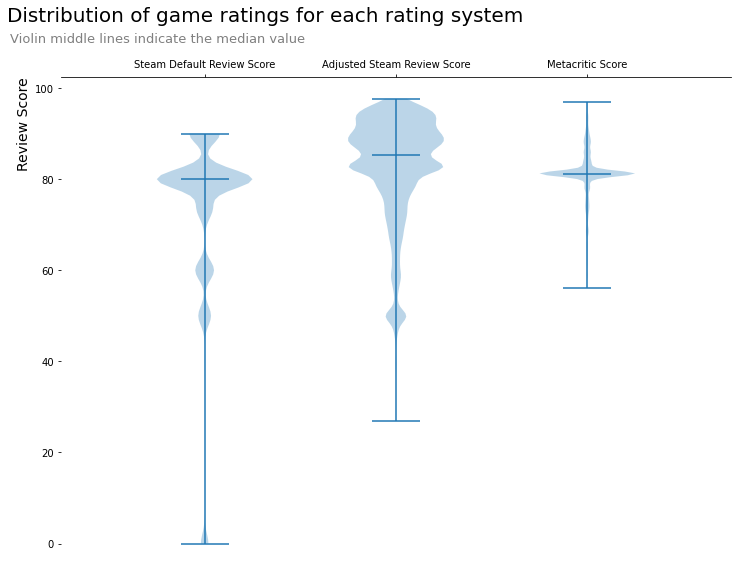

In [96]:
# Define a function for setting the styling of the axis
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.xaxis.tick_top()
    ax.set_ylabel("Review Score", size = 14, loc = "top")

# Title of each rating system available
titles = ["Steam Default Review Score","Adjusted Steam Review Score","Metacritic Score"]

# Assign variables to each "rating" column
review_score = steam_data["review_score"] * 10 # <- multiply this column by 10 to scale appropriately with other two columns
rating = steam_data["rating"]
metacritic_score = steam_data["metacritic_score"]

# Plot results
fig, ax = plt.subplots(figsize = (12,9))
plt.violinplot([review_score, rating, metacritic_score], showmedians=True)

# Remove all borders except top border
plt.gca().spines[["right", "left","bottom"]].set_visible(False)

# Title and subtext
plt.title("Distribution of game ratings for each rating system", size = 20, x = 0.305, y = 1.1)
plt.text(x = -.015, y = 110, s = "Violin middle lines indicate the median value", size = 13, color = "grey")
set_axis_style(ax, titles)

In [97]:
correlation_1 = round(steam_data["review_score"].corr(steam_data["average_players"]), 2)

correlation_2 = round(steam_data["rating"].corr(steam_data["average_players"]), 2)


print(f"Correlation between review score and the average monthly player count: {correlation_1}")

print(f"Correlation between the adjusted review score (rating) and the average monthly player count: {correlation_2} ")


Correlation between review score and the average monthly player count: 0.02
Correlation between the adjusted review score (rating) and the average monthly player count: -0.01 


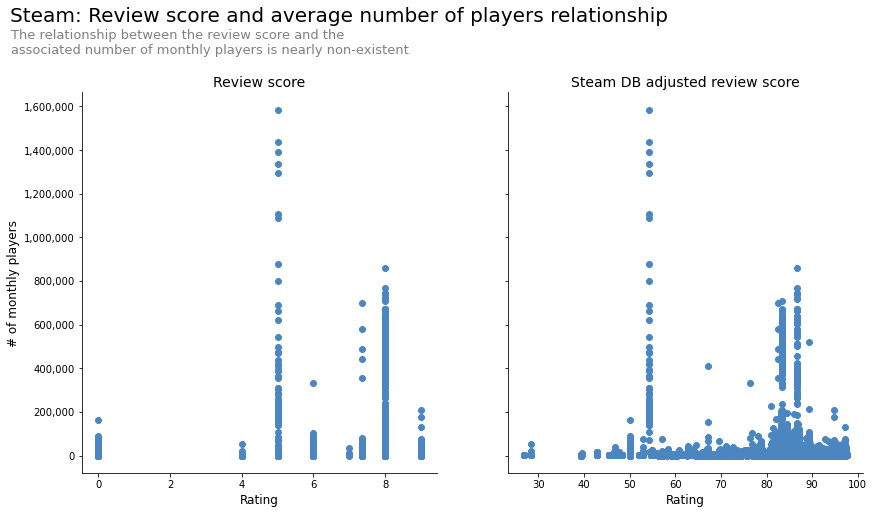

In [98]:

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,7),gridspec_kw={'width_ratios': [1,1]})
# Add the main title
fig.suptitle("Steam: Review score and average number of players relationship", fontsize=20, x=0.38, y = 1.05)

ax1.scatter(steam_data["review_score"], steam_data["average_players"], color = "#4B86C1")
ax1.spines[["right", "top"]].set_visible(False)
ax1.ticklabel_format(useOffset=False, style='plain', axis = "y")
# Set y axis ticks with commas
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.set_title("Review score", size = 14)

# X and Y labels
ax1.set_xlabel("Rating", size = 12)
ax1.set_ylabel("# of monthly players", size = 12)
ax2.set_xlabel("Rating", size = 12)

ax2.scatter(steam_data["rating"], steam_data["average_players"], color = "#4B86C1")
ax2.spines[["right", "top"]].set_visible(False)
ax2.set_title("Steam DB adjusted review score", size = 14)

plt.text(x=-85.5, y=1840000, s='''The relationship between the review score and the
associated number of monthly players is nearly non-existent''', size = 13, color = "grey")

plt.show()

### Average and median playtime on Steam
heatmap?

In [99]:
playtime = steam_data.groupby("game")[["median_playtime","average_playtime"]].mean()
playtime.sort_values(by="average_playtime",ascending=False).head(20)

,median_playtime,average_playtime
game,,
Firestone Idle RPG,48663.00,41854.00
Gems of War,1375.00,41285.00
X-Plane 11,57446.00,38676.00
Dota 2,896.00,37871.00
Counter-Strike: Global Offensive,6104.00,30053.00
PUBG: BATTLEGROUNDS,7525.00,22858.00
Battle Brothers,38101.00,22718.00
FINAL FANTASY XIV Online,5409.00,22149.00
Cookie Clicker,11260.00,19308.00


### Seasonal trends



If you're a streamer on youtube, twitch or any other platform that people use to watch gaming content it's neccessary to know the "seasonality" of your audience. Seasonality is typical within many industries, for example I think it's reasonable to say that in the Northern Hemisphere travel/tourism and vacationing increase during the warmer months. Retailers might see an increase in customers in the holidays, and less in the New Year.

Trends can be spottend on Steam and Twitch. It's important to understand that viewership will drop during certain times in the year so that you are not surprised when less people are watching. I would suspect that it would be equally important to know when the viewership peaks. Perhaps during peak season there may opportunities to stream more, or explore new content.

I noticed that the Steam data suggests that people typically play more during late fall and winter. This makes sense, because in North America and Europe the weather is usually not favorable for outside activities. This is also when schools have breaks for holidays, so students have time to enjoy leisure activities more often. 

Around spring or early summer player activity on Steam sharps droply, but you will notice a slight increase again around May/June (maybe end of school year). Gaming on Steam is at it's lowest in the summer, which I would expect is due to vacationing and other outdoor activites.

Seasonality on Twitch follows a similar pattern, but there is a noticable difference. It looks like around February or March, there is a significant drop in the number of people watching content on Twitch. From May through June viewership is at its highest, followed by a sharp decrease. The patterns for both sets of data are about the same, but Twitch seasonality is rather "offset" by a few months. Expect less people to be watching Twitch content in late summer and early fall, but it picks up again later in the year around the holidays and new years.


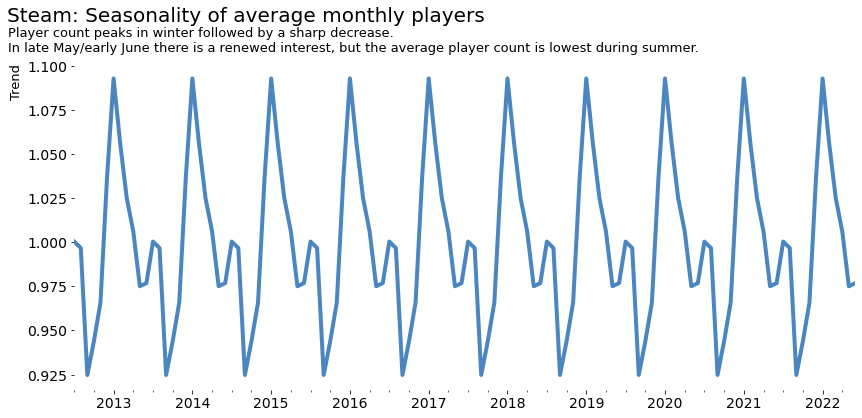

In [100]:
player_avg = steam_data.sort_index()

player_avg = player_avg.reset_index()[["month","average_players"]].groupby("month").mean()
result_steam = seasonal_decompose(player_avg, model = "multiplicative")
result_steam.seasonal.plot(figsize = (14,6), linewidth = 4, color = "#4B86C1")

# Remove borders and x label
plt.gca().spines[["right", "left", "top", "bottom"]].set_visible(False)
plt.xlabel("")

# Y label
plt.ylabel("Trend", loc = "top", size = 13)

# X and Y ticks
plt.yticks(size = 14)
plt.xticks(size = 14)

# Title and subtext
plt.title("Steam: Seasonality of average monthly players", x=0.22, y=1.11, size = 20)
plt.text(x = 499.9, y = 1.108,

s ='''Player count peaks in winter followed by a sharp decrease.
In late May/early June there is a renewed interest, but the average player count is lowest during summer.''', size = 13)

plt.show()

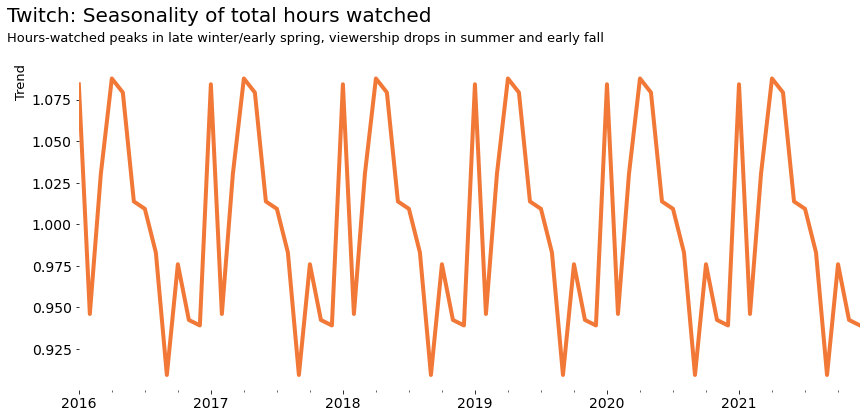

In [101]:
hours_watched = twitch_global.sort_index()["Hours_watched"]
result_twitch = seasonal_decompose(hours_watched,model = "multiplicative")
result_twitch.seasonal.plot(figsize = (14,6), linewidth = 4, color = "#f17837")
# Change y tick labels to non-scientific notation
#plt.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Remove borders and x label
plt.gca().spines[["right", "left", "top", "bottom"]].set_visible(False)
plt.xlabel("")

# Y label
plt.ylabel("Trend", loc = "top", size = 13)

# X and Y ticks
plt.yticks(size = 14)
plt.xticks(size = 14)

# Title and subtext
plt.title("Twitch: Seasonality of total hours watched", x=0.18, y=1.11, size = 20)
plt.text(x = 545.5, y = 1.11,

s ="Hours-watched peaks in late winter/early spring, viewership drops in summer and early fall", size = 13)

plt.show()

### Steam data player spike 2018
Refer to this link:

*https://arstechnica.com/gaming/2018/08/is-fortnite-to-blame-for-steams-falling-user-numbers-this-year/*

In the chart above, *Steam: total monthly players (2012 - 2022)* you'll notice about three large peaks. One in 2018, mid-late 2020, and 2022. The last two are more easily explained by COVID-19 lockdowns indirectly inflating player counts on Valve's platform. The 2018 peak is less explainable, so I did some searching online and found an article written in August 2018 (link above).

To summarize, the article explains it's possible that the most popular title in 2018 (on Steam), *Playerunknown's Battlegrounds*, experienced a significant increase in average player count in January 2018 with a significant loss by the end of the year. This article mentions that during this time, Epic Games (a competitor to Valve's Steam client) released *Fortnite*. As both titles have similar gameplay, the popularity of this title may have had diverted player interest away from *Playerunknown's Battlegrounds*. 
In short, *Playerunknown's Battlegrounds*' average monthly player count seems to have drastically skewed the overall average player count in late 2017 to mid 2018.

To verify this within the data locally, I sliced the steam charts data to include all rows only from the start of 2017 to the end of 2018. With this slice I performed data filtering to only include rows that have values in the "average_players" column that are greater than the overall average "average_players" of this slice. Further sorting shows that during this time period *Playerunknown's Battlegrounds* had the highest average player count for several months.



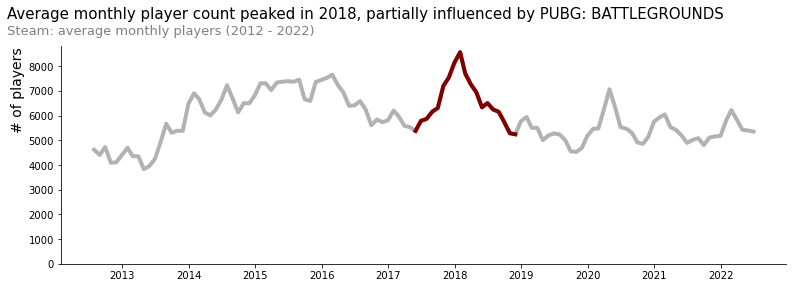

In [102]:
y_2017_2018 = steam_data.loc["2017-05-01":"2018-12-01"]
# Plot results
fig, ax = plt.subplots(figsize = (13,4))


# Resample the player data on a monthly scale, calculate the sum
plt.plot(steam_data.resample("M")["average_players"].mean(), linewidth = 4, color = "grey", alpha = 0.6)
plt.plot(y_2017_2018.resample("M")["average_players"].mean(), color = "maroon", linewidth = 4)
#plt.axvline(dt.datetime(2020, 3, 15), color = "grey")
#plt.axvspan(dt.datetime(2020,3,15),dt.datetime(2023,1,1), color = "black", alpha = 0.2)
plt.ylabel("# of players", size = 14, loc = "top")

# Remove borders
plt.gca().spines[["right", "top"]].set_visible(False)

plt.title("Average monthly player count peaked in 2018, partially influenced by PUBG: BATTLEGROUNDS", size = 15, x = 0.42, y = 1.1)
plt.text(x = 15075, y = 9300,
s = "Steam: average monthly players (2012 - 2022)",
size = 13, color = "grey")
plt.ylim(0)
plt.show()


To further illustrate my point, I performed dataframe filtering and slicing for steam player data from the beginning of 2017 up to the end of 2018.
I gathered all the rows that had average player counts greater than the average of the dataframe slice from 2017 to 2018. With only these rows selected, I sorted every row by the "average_players" column in descending order. There were duplicates, of course, since this is time series data with multiple months/games.

To produce the final table (below) with each unique game sorted by "average_players" I had to drop duplicates, keeping only the first row for each. This amount of code will create a table for the top 10 games sorted by players within the timeframe of 2017 to the end of 2018.


*Steam (2017 - 2018): Average monthly players (Top 5 titles)*:

I wanted to use this table to show which games were "most popular" during this timeframe. When comparing *Playerunknown's Battlegrounds* to the other most popular titles, you can see how drastic the difference is. There is a no doubt a large spike in the number of people that started playing this title, but this was short-lived, as noted by the large drop-off in player count over the next few months. The other popular titles tend to have a consistent trend.

In [103]:
# Slice steam charts data from 2017 to 2018
y_2017_2018 = steam_data.loc["2017-01-01":"2019-01-01"]

# Filter sliced dataframe for rows with greater than average values in average_players column
# Reassign to new variable
above_avg_17_18 = y_2017_2018[y_2017_2018["average_players"] > y_2017_2018["average_players"].mean()]

# Slice dataframe to include only game and average_players columns
# Sort by average_players in descending order
# Reassign to new variable
player_averages = above_avg_17_18[["game","average_players"]].sort_values(by = "average_players", ascending = False)

# Drop duplicates of based on name of game
player_averages.drop_duplicates(subset = "game", keep = "first").head(10)

,game,average_players
month,,
2018-01-31,PUBG: BATTLEGROUNDS,1584886.77
2017-02-28,Dota 2,591567.25
2017-02-28,Counter-Strike: Global Offensive,402385.71
2018-08-31,Monster Hunter: World,188291.24
2018-03-31,Tom Clancy's Rainbow Six Siege,83112.29
2017-06-30,PAYDAY 2,80779.88
2018-07-31,Grand Theft Auto V,80395.34
2018-07-31,Warframe,76594.91
2017-10-31,Team Fortress 2,54963.29


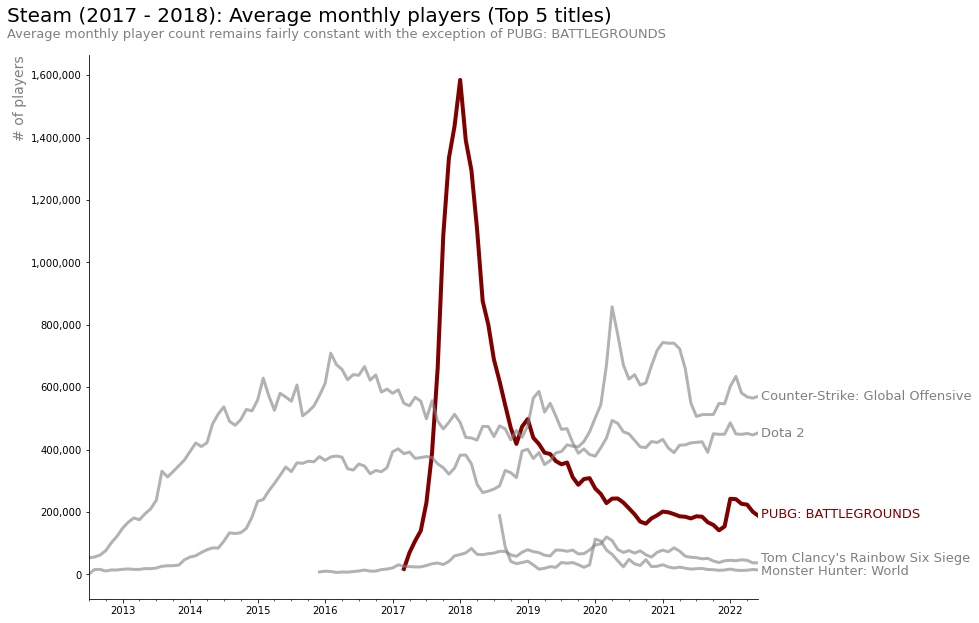

In [104]:

# Top 5 games with the highest average monthly player count (2017 to 2018)
pubg = steam_data[steam_data["game"] == "PUBG: BATTLEGROUNDS"]
dota = steam_data[steam_data["game"] == "Dota 2"]
csgo = steam_data[steam_data["game"] == "Counter-Strike: Global Offensive"]
mhw = steam_data[steam_data["game"] == "Monster Hunter: World"]
rss = steam_data[steam_data["game"] == "Tom Clancy's Rainbow Six Siege"]


# Plot results
fig, ax = plt.subplots(figsize = (12,10))
ax1 = pubg.resample("M")["average_players"].mean().plot(linewidth = 4, color = "maroon")
ax2 = dota.resample("M")["average_players"].mean().plot(linewidth = 3, color = "grey", alpha = 0.6)
ax3 = csgo.resample("M")["average_players"].mean().plot(linewidth = 3, color = "grey", alpha = 0.6)
ax4 = mhw.resample("M")["average_players"].mean().plot(linewidth = 3, color = "grey", alpha = 0.6)
ax5 = rss.resample("M")["average_players"].mean().plot(linewidth = 3, color = "grey", alpha = 0.6)

# Remove scientific notation y axis
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Set y axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Remove x label
plt.xlabel("")
plt.ylabel("# of players",size = 14, loc = "top", color = "grey")

# Labels
plt.text(629.5,180000,"PUBG: BATTLEGROUNDS", color = "maroon", size = 13)
plt.text(629.5,440000,"Dota 2", color = "grey", size = 13)
plt.text(629.5,560000,"Counter-Strike: Global Offensive", color = "grey", size = 13)
plt.text(629.5,0,"Monster Hunter: World", color = "grey", size = 13)
plt.text(629.5,40000,"Tom Clancy's Rainbow Six Siege", color = "grey", size = 13)


# Remove spines
plt.gca().spines[["right", "top"]].set_visible(False)

plt.title("Steam (2017 - 2018): Average monthly players (Top 5 titles)", size = 20, x = 0.33, y = 1.05)
plt.text(x = 495.5, y = 1720000,
s = "Average monthly player count remains fairly constant with the exception of PUBG: BATTLEGROUNDS", 
size = 13, color = "grey")

plt.show()

### Twitch game data

In [105]:
twitch_game.head()

,Game,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
date,,,,,,,,,,
2016-01-31,League of Legends,1,94377226,1362044,530270,2903,129172,127021,1833,69.29
2016-01-31,Counter-Strike: Global Offensive,2,47832863,830105,372654,2197,120849,64378,1117,57.62
2016-01-31,Dota 2,3,45185893,433397,315083,1100,44074,60815,583,104.26
2016-01-31,Hearthstone,4,39936159,235903,131357,517,36170,53749,317,169.29
2016-01-31,Call of Duty: Black Ops III,5,16153057,1151578,71639,3620,214054,21740,1549,14.03


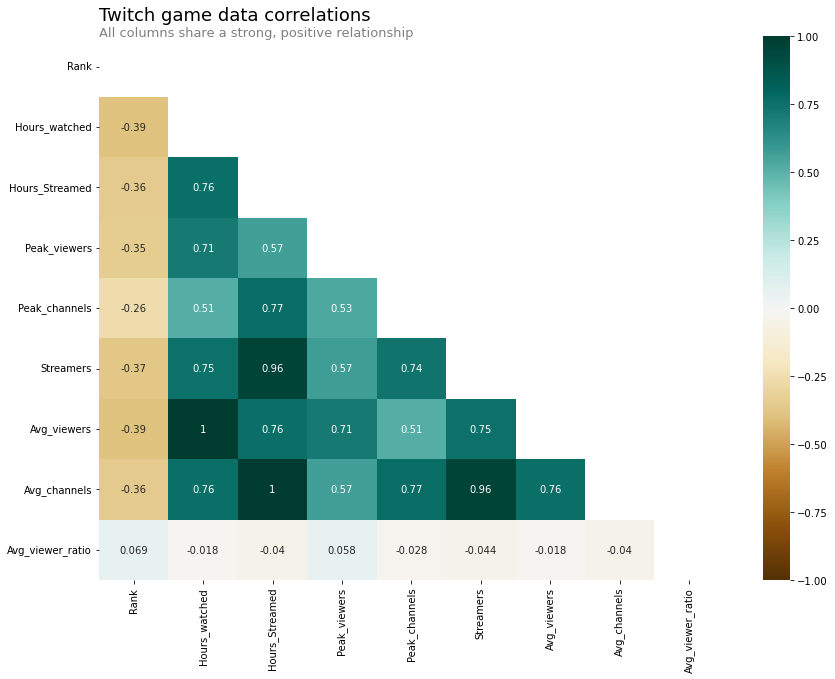

In [106]:
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(twitch_game.corr(), dtype=bool))

heatmap = sns.heatmap(twitch_game.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title("Twitch game data correlations", fontdict={'fontsize':18}, pad=16, loc = "left")
plt.text(x = 0, y = 0, s = "All columns share a strong, positive relationship ", size = 13, color = "grey")
plt.show()

### Most watched categories

Something about the highest categories

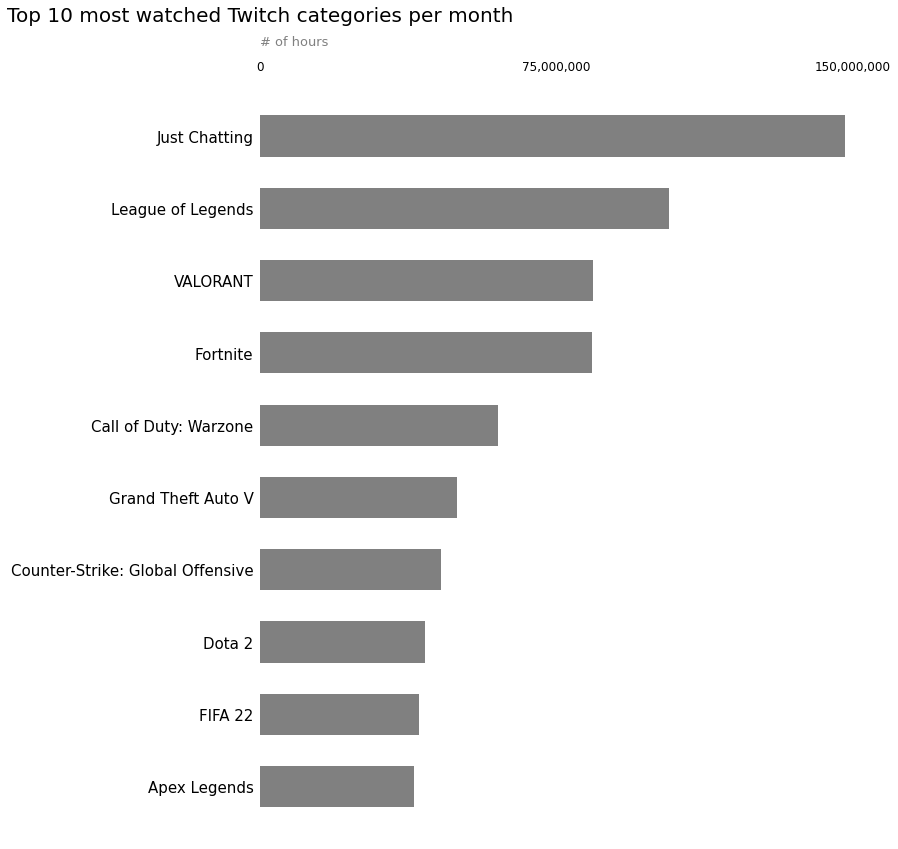

In [107]:
top_10 = twitch_game.groupby("Game", as_index=False).mean().sort_values(by="Hours_watched",ascending=False).head(10)

fig,ax = plt.subplots(figsize = (11,14))
plt.barh(top_10["Game"], top_10["Hours_watched"], color = "grey", height = 0.57)
plt.gca().invert_yaxis()
ax.set_xticks([0, 75000000, 150000000])

# Change x tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "x")


# Set x axis ticks with commas
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Remove borders
plt.gca().spines[["right", "left", "top", "bottom"]].set_visible(False)

plt.title("Top 10 most watched Twitch categories per month", size = 20, x = 0, y = 1.07)
plt.text(x = 1, y =-1.25, s = "# of hours", size = 13, color = "grey")
# X axis to top
ax.xaxis.tick_top()
ax.tick_params(bottom=False, left=False)
ax.tick_params(top=False, left=False)
# X and Y ticks
plt.xticks(size = 12)
plt.yticks(size = 15) # color
plt.show()

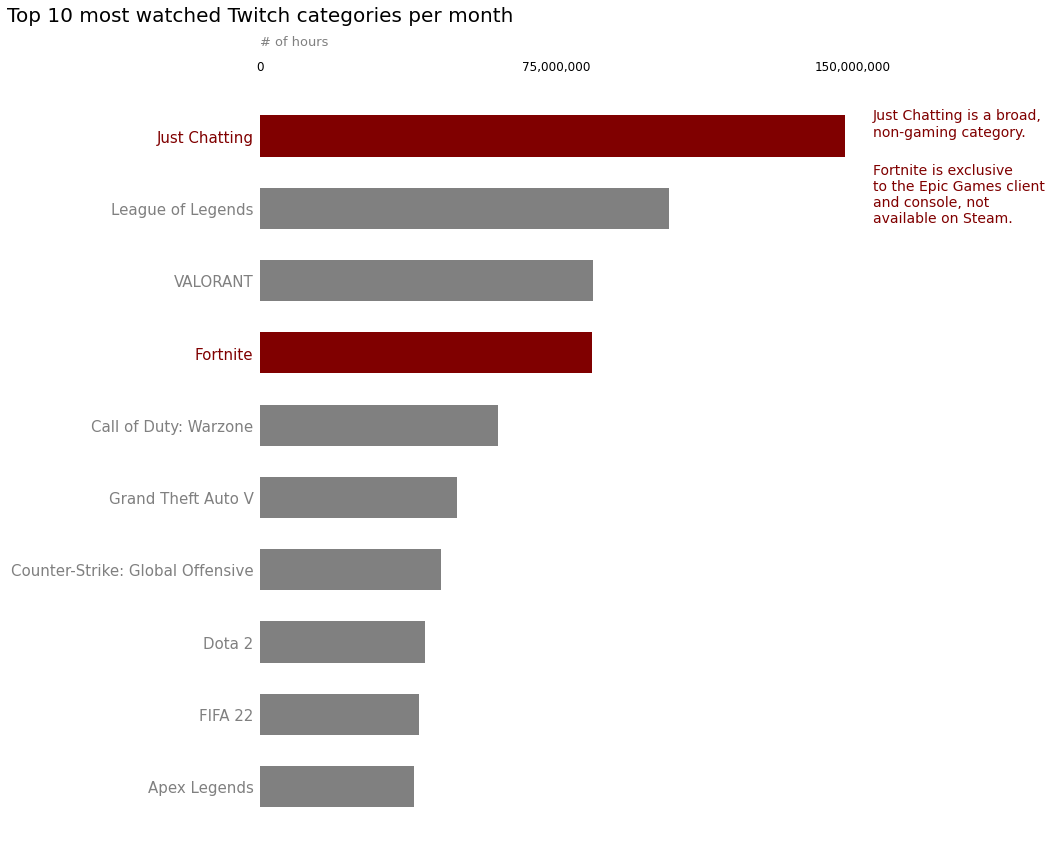

In [108]:
colors = [
    'maroon',
    'grey',
    'grey',
    'maroon',
    'grey',
    'grey',
    'grey',
    'grey',
    'grey',
    'grey'
    ]

fig,ax = plt.subplots(figsize = (11,14))
plt.barh(top_10["Game"], top_10["Hours_watched"], height = 0.57, color = colors)
plt.gca().invert_yaxis()
ax.set_xticks([0, 75000000, 150000000])

# Change x tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "x")


# Set x axis ticks with commas
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Remove borders
plt.gca().spines[["right", "left", "top", "bottom"]].set_visible(False)

plt.title("Top 10 most watched Twitch categories per month", size = 20, x = 0, y = 1.07)
plt.text(x = 1, y =-1.25, s = "# of hours", size = 13, color = "grey")

plt.text(x=155000000, y = 0, s = '''Just Chatting is a broad,
non-gaming category.''', size = 14, color = "maroon")

plt.text(x=155000000, y = 1.2, s = '''Fortnite is exclusive
to the Epic Games client
and console, not 
available on Steam.''', size = 14, color = "maroon")

# X axis to top
ax.xaxis.tick_top()
ax.tick_params(bottom=False, left=False)
ax.tick_params(top=False, left=False)
# X and Y ticks
plt.xticks(size = 12)
plt.yticks(size = 15) # color

# Y ticks
plt.yticks(color = "grey")

plt.gca().get_yticklabels()[0].set_color("maroon")
plt.gca().get_yticklabels()[3].set_color("maroon")


plt.show()

In [109]:
twitch_game["month"] = twitch_game.index.month_name()

In [110]:
twitch_game.describe()

,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
count,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00
mean,100.50,4782757.99,157125.30,55096.80,586.40,17224.46,6554.21,214.87,81.88
std,57.74,16679490.00,542829.50,132917.88,2721.16,54533.41,22859.34,743.88,368.89
min,1.00,89811.00,19.00,441.00,1.00,0.00,120.00,0.00,1.95
25%,50.50,368179.00,12212.00,8351.00,51.50,1479.00,504.00,16.00,16.12
50%,100.00,819895.00,31630.00,20169.00,122.00,4126.00,1125.00,43.00,29.16
75%,150.00,2295441.00,88728.00,45986.00,318.00,10712.00,3159.00,121.00,57.80
max,200.00,344551979.00,10245704.00,3123208.00,129860.00,1013029.00,479209.00,13789.00,13601.87


### Multiplayer games on Steam and Twitch
Logic here is that we should only be interested in games that have positive player growth on steam. By extension, twitch viewers will more likely be interested in games that have an active player base.

What are some of the highest watched categories on Twitch? You'll see that the most watched categories (by average number of hours per month) are typically multiplayer games. The top 10 categories on twich except for *Just Chatting*, have prominent multiplayer features. You can't tell by just looking at the graph above (*Top 10 most watched Twitch categories per month*), but as someone familiar with gaming I know that people play these games for the multiplayer aspect.

As of 2022, the top 5 titles by average monthly player count on Steam:
- *PUBG: BATTLEGROUNDS*
- *Dota 2*
- *Counter-Strike: Global Offensive* 
- *Monster Hunter: World* 
- *Tom Clancy's Rainbow Six Siege*

The main appeal of these titles is the multiplayer aspect. I think *Monster Hunter: World* is the only one that is more geared towards single player, but it does have a cooperative/multiplayer feature too. I would argue people tune into Twitch enjoy watching livestreams of multiplayer games, otherwise the monthly averages for hours watched would be lower. 

With this in mind, it doesn't mean you should start streaming multiplayer games just because they are the most popular with most audiences. If you're not really a fan of a certain category, then don't play it. It probably won't be a fun experience if you are playing multiplayer games if you don't like them, and any one watching will probably notice this quickly.

I needed to fairly compare the popular multiplayer games on Steam and Twitch, but to accomplish this I had to perform some data slicing. To recall, data for Steam player trends is very recent (up to June 2022). The Twitch datasets from *Kaggle.com* only include up to the end of 2021. I had to make sure I was comparing the popular games on Steam in **2021** to popular games on Twitch.

The pandas library allows you to slice time series data based on whichever dates a user may need. I calculated monthly player growth (how many new people are playing a game) of the multiplayer games on Steam from January 2021 to December 2021. I discovered some differences between what people are playing versus what they are watching on Twitch.

In 2021, *Dota 2*, *FIFA 22*, and *Apex Legends* were the most popular multiplayer games to watch on Twitch. However, on Steam *Football Manager 2022* was by far the most popular multiplayer game during 2021. *Apex Legends* was second by a far smaller margin followed by *Final Fantasy XIV Online*.

In [111]:
# Read in dataframe for Steam tags 
tags = pd.read_csv(r"data_files\steamspy_tag_data.csv")

In [112]:
# Select columns from tags data that contain multiplayer/co-op related tags
tags = tags[['appid','co_op','co_op_campaign','competitive','free_to_play','mmorpg','massively_multiplayer','multiplayer','e_sports']]

# Left join data 
steam_tags_data = pd.merge(steam_data, tags, how="left", left_on="app_id", right_on="appid")

# Select multiplayer tag columns
steam_tags_data = steam_tags_data[
    [
        "game",
        "average_players",
        "player_gain",
        'co_op',
        'co_op_campaign',
        'competitive',
        'free_to_play',
        'mmorpg',
        'massively_multiplayer',
        'multiplayer',
        'e_sports'
        ]
        ]

# Add all tag columns into a new column
steam_tags_data["tag_count"] = steam_tags_data[
    [
        'co_op',
        'co_op_campaign',
        'competitive',
        'free_to_play',
        'mmorpg',
        'massively_multiplayer',
        'multiplayer',
        'e_sports'
        ]
        ].sum(axis=1)

# Select rows with a sum greater than or equal to 1, which indicates if game has multiplayer features
multiplayer_list = steam_tags_data[steam_tags_data["tag_count"] >=1]["game"].unique().tolist()

# Get the average player gain for the year 2021 (Jan-Dec)
player_gain = steam_data["2021-01-31":"2021-12-31"].groupby("game",as_index=False)["player_gain"].mean()

# Filter to include only multiplayer games
multiplayer_games = player_gain[player_gain["game"].isin(multiplayer_list)]

# Multiplayer games with greater than 0 player gain
multiplayer_games = multiplayer_games[multiplayer_games["player_gain"] > 0]

# Sort this dataframe by the player gain column in descending order (highest to lowest)
multiplayer_games = multiplayer_games.sort_values(by="player_gain",ascending=False)




Fifa 22
Apex legends
Dota 2

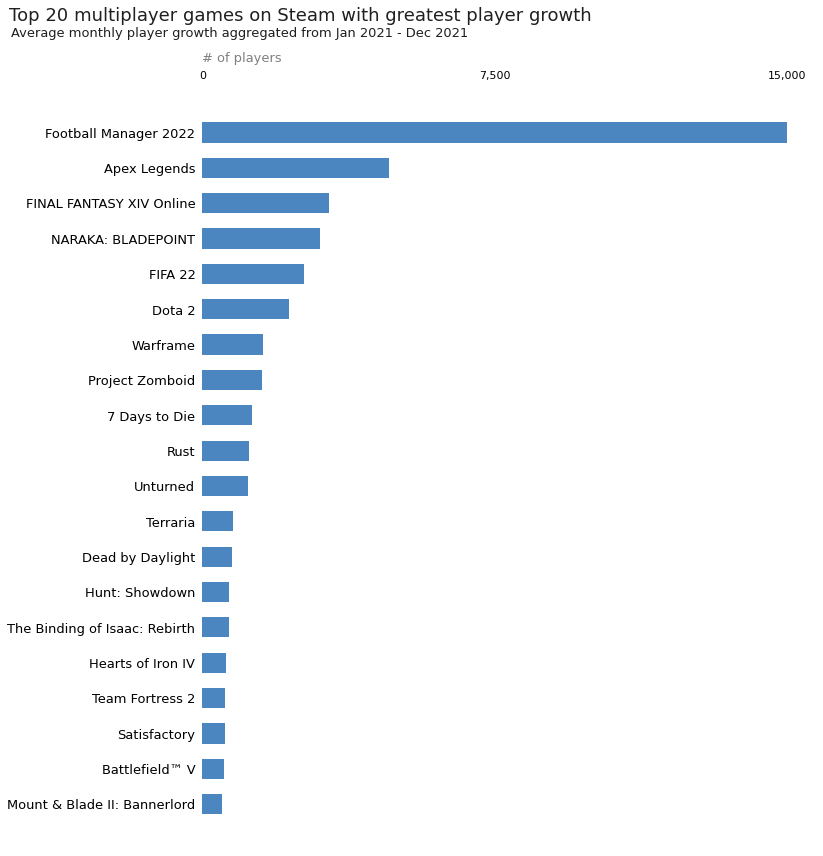

In [113]:
fig,ax = plt.subplots(figsize = (11,14))
plt.barh(multiplayer_games["game"].head(20), multiplayer_games["player_gain"].head(20),height = 0.57, color = "#4B86C1")
plt.gca().invert_yaxis()
ax.set_xticks([0, 7500, 15000])

# Set x axis ticks with commas
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Remove borders
plt.gca().spines[["right", "left", "top", "bottom"]].set_visible(False)

plt.title("Top 20 multiplayer games on Steam with greatest player growth", size = 18, x = 0.16, y = 1.08, color = "#202020")
plt.text(x=-4900, y=-2.7, s="Average monthly player growth aggregated from Jan 2021 - Dec 2021", size = 13, color = "#202020")
plt.text(x=0, y = -2, s = "# of players", size = 13, color = "grey")

# X axis to top
ax.xaxis.tick_top()
ax.tick_params(bottom=False, left=False)
ax.tick_params(top=False, left=False)
# X and Y ticks
plt.xticks(size = 11)
plt.yticks(size = 13)

plt.show()

In [114]:
# Get a list of the names of all multiplayer games with positive player growth
twitch_multiplayer_filter = multiplayer_games["game"].unique().tolist()

# Use twitch_multiplayer_filter to return a dataframe of games only from the list
twitch_multiplayer_games = twitch_game[twitch_game["Game"].isin(twitch_multiplayer_filter)]

# Group by "Game"
group_twitch_games = twitch_multiplayer_games.groupby("Game", as_index=False).mean()

# Sort dataframe by the average number of viewers in descending order
viewers_sorted = group_twitch_games.sort_values(by="Avg_viewers",ascending=False)

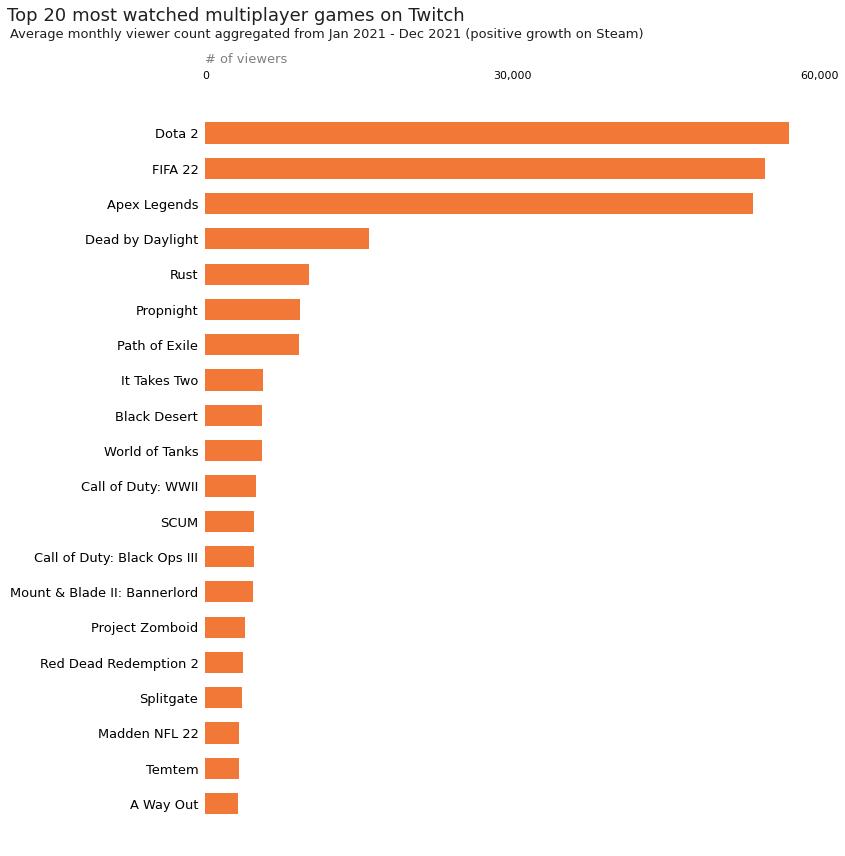

In [115]:
fig,ax = plt.subplots(figsize = (11,14))
plt.barh(viewers_sorted["Game"].head(20), viewers_sorted["Avg_viewers"].head(20), height=0.6, color = "#f17837")
plt.gca().invert_yaxis()
ax.set_xticks([0, 30000, 60000])

# Set x axis ticks with commas
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Remove borders
plt.gca().spines[["right", "left", "top", "bottom"]].set_visible(False)

plt.title("Top 20 most watched multiplayer games on Twitch", size = 18, x = 0.05, y = 1.08, color = "#202020")
plt.text(x=-19100, y=-2.7, s="Average monthly viewer count aggregated from Jan 2021 - Dec 2021 (positive growth on Steam)", size = 13, color = "#202020")
plt.text(x=0, y = -2, s = "# of viewers", size = 13, color = "grey")

# X axis to top
ax.xaxis.tick_top()
ax.tick_params(bottom=False, left=False)
ax.tick_params(top=False, left=False)

# X and Y ticks
plt.xticks(size = 11)
plt.yticks(size = 13)

plt.show()

In [116]:
twitch_game.sample()

,Game,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,month
date,,,,,,,,,,,
2016-12-31,Vainglory,76,641527,8034,23099,27,221,863,10,79.85,December


### Average channels/ viewer ratio

When I was getting to know the twitch game data, I was curious what the "Avg_viewer_ratio" column represented. This column is the average number of viewers per channel for each game. It's roughly the calculation of "Avg_viewers" (the average per month of how many people watch a game) divided by "Avg_channels" (average number of channels per month for each game).

For example, in September of 2019, *Hearthstone* had an average of 23,152 viewers in that month. 137 distinct channels streamed that game live over the course of that month. 

**"Avg_vewers" (23,152) / "Avg_channels" (137) = "Avg_viewer_ratio" 168.18**. For each channel on *Hearthstone*, about 168 people were tuned in to a livestream.

Using the average viewer ratio as a metric may indicate whether or not people are interested in a game on twitch. Let's say that one game has a high average number of monthly viewers, and a high average of channels streamed. If the average viewer ratio is rather low compared to these other two columns, it might be reasonable to say there is an excessive number of people streaming a game. 

For example, *Apex Legends* has an average of 53,505 viewers per month. The number of distinct channels that typically stream that game is 3,556. This results in an average viewer ratio of about **14** people per channel. I may consider that *Apex Legends* is oversaturated with livestreamers, however, this does not automatically rule out games with low viewer ratios. This may serve as an indication that an attempt get noticed on Twitch with this title may be more difficult.

What would you need to look for if you use the average viewer ratio as a metric for deciding what to play? I may look for games with high average monthly viewers, with not too many channels. This would result in a high average viewer ratio, which means there may be room to gain viewers. Some examples include *New World*, *Dota 2*, *Cyberpunk 2077*, *Rust*, *Baldur's Gate 3*, *Old School RuneScape*, and *Path of Exile*.

Fewer examples of older games

I thought the age of a game may have had an influence on the number of average viewers, but I was proved wrong. By age, I mean the number of years that have passed since the release date of the game. I had a hunch that this might have been the case when I was looking through the raw twitch game data. To attempt to find an answer I had to merge the "release_year" column (from one of the steam datasets) to the current twitch game data. Simply by subtracting the "release_year" column from 2021 it will return the age of the game.

The correlation between age and the number of viewers a game receives is less than 1% (nearly no correlation). However, it is true that within this dataset, games older than about 8 years old, with a few exceptions have less than 10,000 average viewers per month. Games less than 8 years old more often have higher averages.

In [117]:
twitch_game.describe()

,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
count,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00
mean,100.50,4782757.99,157125.30,55096.80,586.40,17224.46,6554.21,214.87,81.88
std,57.74,16679490.00,542829.50,132917.88,2721.16,54533.41,22859.34,743.88,368.89
min,1.00,89811.00,19.00,441.00,1.00,0.00,120.00,0.00,1.95
25%,50.50,368179.00,12212.00,8351.00,51.50,1479.00,504.00,16.00,16.12
50%,100.00,819895.00,31630.00,20169.00,122.00,4126.00,1125.00,43.00,29.16
75%,150.00,2295441.00,88728.00,45986.00,318.00,10712.00,3159.00,121.00,57.80
max,200.00,344551979.00,10245704.00,3123208.00,129860.00,1013029.00,479209.00,13789.00,13601.87


In [118]:
# Select game and release year columns to prepare for merging
game_age = steam_data[["game","release_year"]]

# Drop any duplicate rows, set the index to "game" column
game_age = game_age.drop_duplicates().set_index("game")

# Subtract the release_year from 2021 to calculate age for each year
game_age["age"] = 2021 - game_age["release_year"] 

# Filter out rows with negative age (steam dataset is newer than 2021, will generate negative values)
game_age = game_age[game_age["age"] >= 0]

# Create a list of all the unique games
steam_games_list = steam_data["game"].unique().tolist()

# Select rows in twitch game data that only appear in the steam games list
twitch_steam_games = twitch_game[twitch_game["Game"].isin(steam_games_list)]

In [119]:
# Groupby each game, calculate mean for selected columns belong
twitch_steam_games_group = twitch_steam_games.groupby("Game")[["Avg_viewers","Avg_channels","Avg_viewer_ratio","Hours_watched"]].mean()

# Sort by the average channels column in descending order
twitch_steam_games_group = twitch_steam_games_group.sort_values(by="Avg_channels", ascending = False)

# Merge the game_age dataframe
twitch_steam_games_group = pd.merge(twitch_steam_games_group, game_age, how = "left", left_index=True,right_index=True).dropna()

# Change data type of age column to integer for easier readability
# Round all values in dataframe to whole number
twitch_steam_games_group["age"] = twitch_steam_games_group["age"].astype(int)
twitch_steam_games_group = twitch_steam_games_group.round().astype(int)

# Separate data

# First 20 games with the highest number average channels
top_20_games = twitch_steam_games_group.head(20)

# Middle section of data
middle_game_data = twitch_steam_games_group.iloc[20:80]

# Bottom 20 games with the least amount of average channels
bottom_20_games = twitch_steam_games_group.tail(20)

In [120]:
twitch_steam_games_group["Avg_viewers"].corr(twitch_steam_games_group["age"])

-0.06258519724421217

Text(-2.7, 77000, 'Average number of monthly viewers on Twitch')

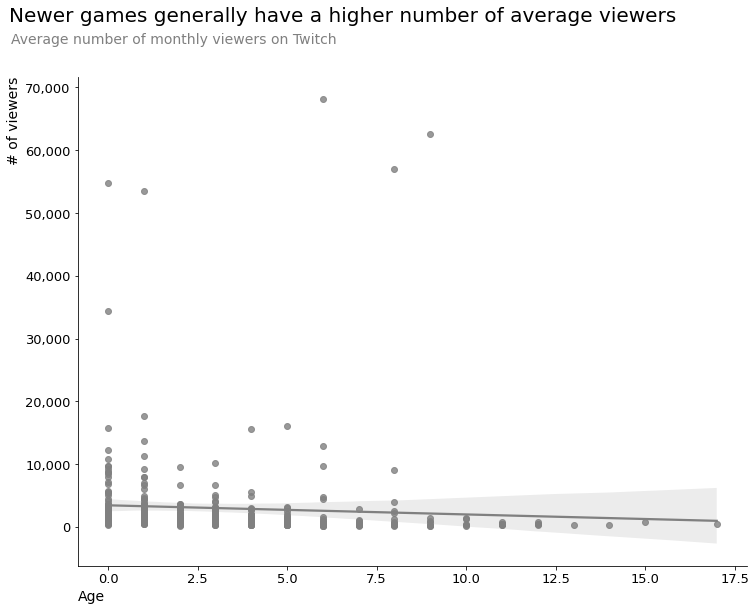

In [121]:
fig, ax = plt.subplots(figsize = (12,9))
sns.regplot(x ="age", y="Avg_viewers", data = twitch_steam_games_group, color = "grey")

# Set y axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Remove borders
plt.gca().spines[["right", "top",]].set_visible(False)

plt.yticks(size = 13)
plt.xticks(size = 13)

plt.ylabel("# of viewers", loc = "top", size = 14)
plt.xlabel("Age", loc = "left", size = 14)

plt.title("Newer games generally have a higher number of average viewers ", size = 20, x = 0.4, y =1.1)
plt.text(x = -2.7, y = 77000, s = "Average number of monthly viewers on Twitch", size = 14, color = "grey")

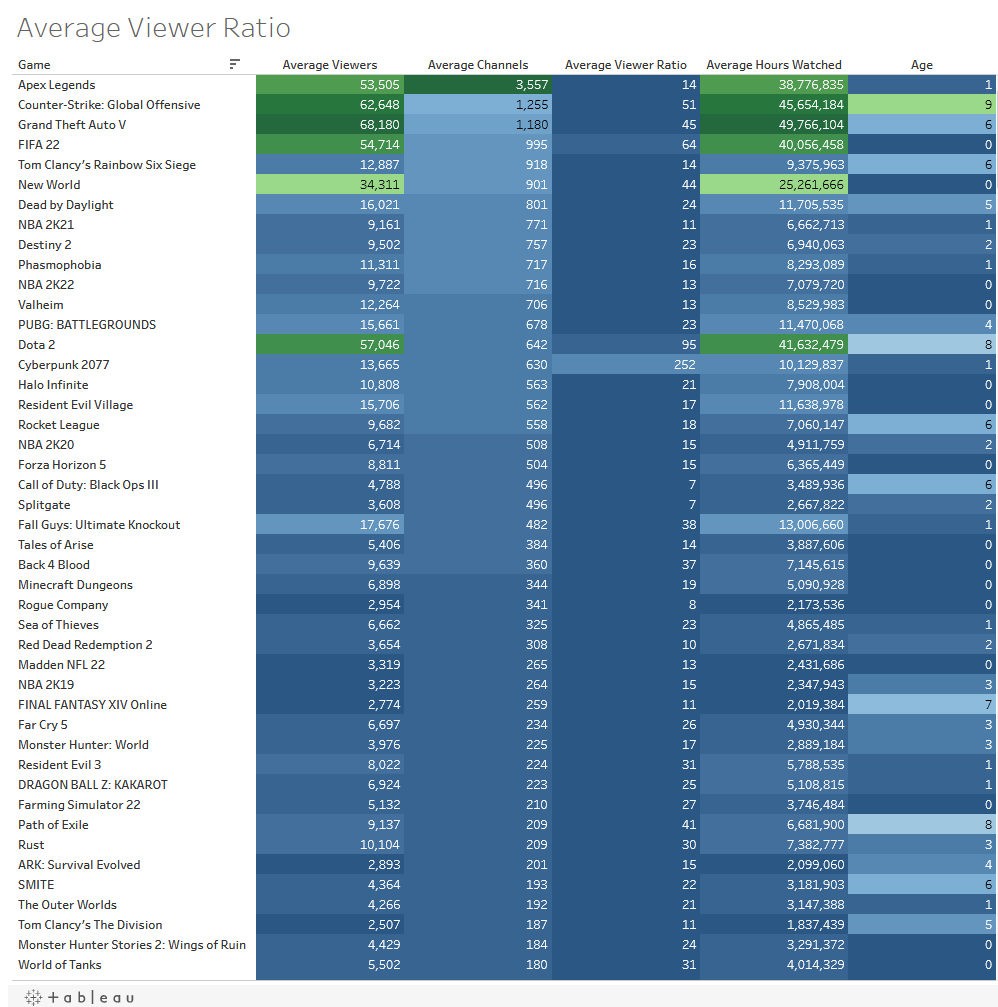

In [127]:

display.Image("Screenshot 2022-09-03 201407.png")


In [122]:

cm = sns.light_palette("#f17837", as_cmap=True)
top_20_games.loc[:,top_20_games.columns != "release_year"].style.background_gradient(cmap = cm)

,Avg_viewers,Avg_channels,Avg_viewer_ratio,Hours_watched,age
Game,,,,,
Apex Legends,53505,3557,14,38776835,1
Counter-Strike: Global Offensive,62648,1255,51,45654184,9
Grand Theft Auto V,68180,1180,45,49766104,6
FIFA 22,54714,995,64,40056458,0
Tom Clancy's Rainbow Six Siege,12887,918,14,9375963,6
New World,34311,901,44,25261666,0
Dead by Daylight,16021,801,24,11705535,5
NBA 2K21,9161,771,11,6662713,1
Destiny 2,9502,757,23,6940063,2


In [123]:
cm = sns.light_palette("#f17837", as_cmap=True)
middle_game_data.loc[:,middle_game_data.columns != "release_year"].style.background_gradient(cmap = cm)

,Avg_viewers,Avg_channels,Avg_viewer_ratio,Hours_watched,age
Game,,,,,
Splitgate,3608,496,7,2667822,2
Call of Duty: Black Ops III,4788,496,7,3489936,6
Fall Guys: Ultimate Knockout,17676,482,38,13006660,1
Tales of Arise,5406,384,14,3887606,0
Back 4 Blood,9639,360,37,7145615,0
Minecraft Dungeons,6898,344,19,5090928,0
Rogue Company,2954,341,8,2173536,0
Sea of Thieves,6662,325,23,4865485,1
Red Dead Redemption 2,3654,308,10,2671834,2


In [124]:

cm = sns.light_palette("#f17837", as_cmap=True)
bottom_20_games.loc[:,bottom_20_games.columns != "release_year"].style.background_gradient(cmap = cm)

,Avg_viewers,Avg_channels,Avg_viewer_ratio,Hours_watched,age
Game,,,,,
Golf It!,590,4,157,433649,4
Prison Architect,190,4,51,142105,6
Danganronpa 2: Goodbye Despair,418,4,101,303181,5
Phoenix Wright: Ace Attorney Trilogy,391,3,106,281404,2
"Papers, Please",706,3,194,473786,8
Railway Empire,411,3,122,276041,3
Cossacks 3,266,3,74,191679,5
Unrailed!,809,3,219,601192,1
S.T.A.L.K.E.R.: Call of Pripyat,314,3,86,233727,11


In [125]:
print("Top 20 titles average age:",top_20_games["age"].mean(),"years")
print("Middle data average age:", round(middle_game_data["age"].mean(),1),"years")
print("Bottom 20 titles average age:", bottom_20_games["age"].mean(),"years")

Top 20 titles average age: 2.6 years
Middle data average age: 2.3 years
Bottom 20 titles average age: 4.7 years


In [126]:
#twitch_steam_games_group = twitch_steam_games_group.reset_index()
#twitch_steam_games_group.to_csv("twitch_viewer_ratio.csv",index=False)